In [31]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ResNet50, InceptionV3, EfficientNetV2B0
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns




In [32]:
# Images Count
count = 0
dirs = os.listdir('Dataset/')
for dir in dirs:
    files=list(os.listdir('Dataset/'+dir))
    print(dir +' Folder has '+str(len(files)) +' Images ')
    count = count + len(files)
print('Dataset has total of '+str(count) +' Images ')


Mild_H_pylori Folder has 862 Images 
Moderate_H_pylori Folder has 653 Images 
Negative_H_pylori Folder has 726 Images 
Severe_H_pylori Folder has 1769 Images 
Dataset has total of 4010 Images 


In [33]:
# Load Dataset
base_dir = 'Dataset/'
img_size = 224  # Resize images to fit pre-trained models
batch_size = 32
epochs = 50

In [34]:
train_ds = image_dataset_from_directory(
    base_dir,
    seed=123,
    validation_split=0.2,
    subset='training',
    batch_size=batch_size,
    image_size=(img_size, img_size)
)

val_ds = image_dataset_from_directory(
    base_dir,
    seed=123,
    validation_split=0.2,
    subset='validation',
    batch_size=batch_size,
    image_size=(img_size, img_size)
)

Found 4010 files belonging to 4 classes.
Using 3208 files for training.
Found 4010 files belonging to 4 classes.
Using 802 files for validation.


In [35]:
disease_names = train_ds.class_names
disease_names

['Mild_H_pylori', 'Moderate_H_pylori', 'Negative_H_pylori', 'Severe_H_pylori']

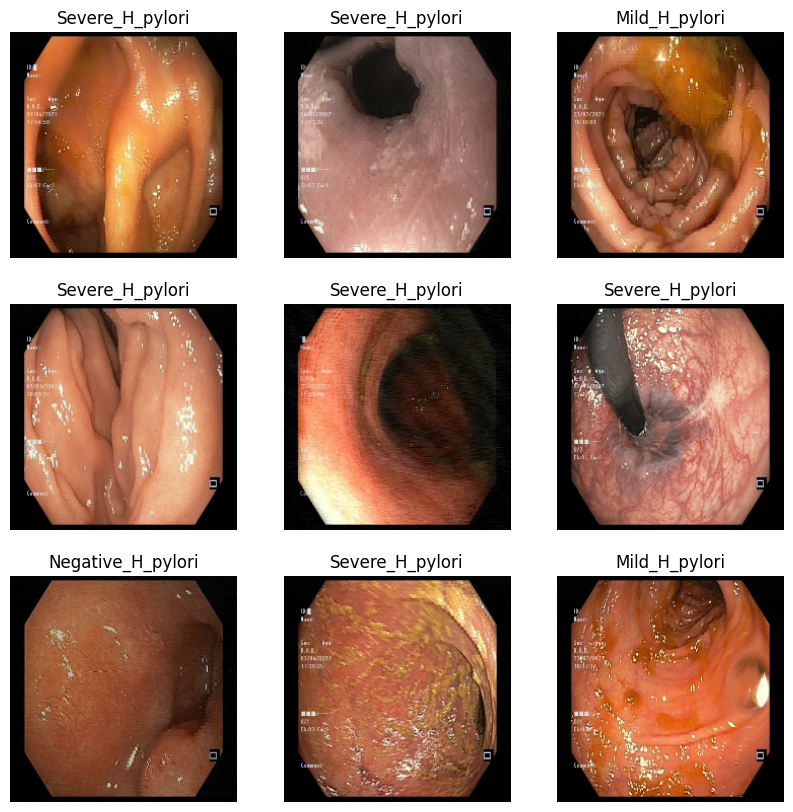

In [36]:
i=0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3,3, i+1)                                # display in row x columns
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(disease_names[labels[i]])
        plt.axis('off')                                      #dimension of images

In [37]:
# Advanced Data Augmentation
# data_augmentation = tf.keras.Sequential([
#     layers.RandomFlip("horizontal", input_shape=(img_size, img_size, 3)),
#     layers.RandomRotation(0.2),
#     layers.RandomZoom(0.2),
#     layers.RandomContrast(0.2),
#     layers.RandomTranslation(0.1, 0.1),
#     layers.RandomBrightness(factor=0.2),
#     layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1),  # Normalize to [-1, 1]
#     layers.experimental.preprocessing.RandomHeight(0.2),
#     layers.experimental.preprocessing.RandomWidth(0.2),
#     layers.experimental.preprocessing.RandomCrop(img_size, img_size),
# ])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_size, img_size, 3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomBrightness(factor=0.2),
    layers.Rescaling(1./127.5, offset=-1),  # Normalize to [-1, 1]
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomCrop(img_size, img_size),
])

In [38]:
# Preprocessing Layer
preprocess_layer = layers.Rescaling(1./255)

In [39]:
AUTOTUNE= tf.data.AUTOTUNE #does'nt have to fetch images from dataset one by one, store images in cache

In [40]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [41]:
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

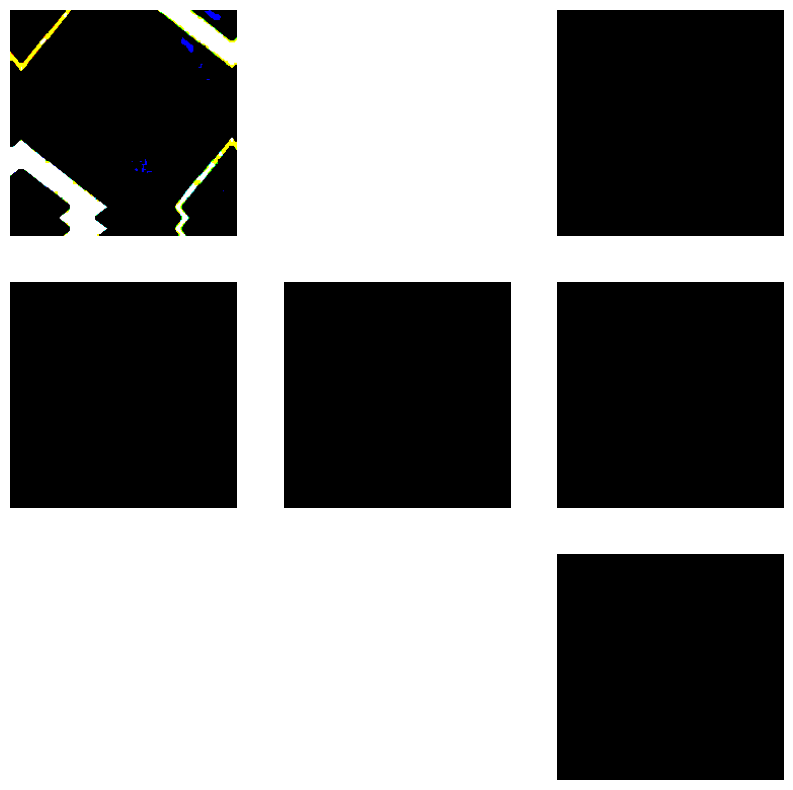

In [42]:
i=0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        images= data_augmentation(images)
        plt.subplot(3,3, i+1)                                # display in row x columns
        plt.imshow(images[0].numpy().astype('uint8'))
        plt.axis('off')                                      #dimension of images

In [43]:
# Attention Mechanism
class AttentionLayer(layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(shape=(input_shape[-1],), initializer='zeros', trainable=True)
        self.u = self.add_weight(shape=(input_shape[-1],), initializer='random_normal', trainable=True)

    def call(self, inputs):
        score = tf.nn.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        attention_weights = tf.nn.softmax(tf.tensordot(score, self.u, axes=1), axis=1)
        weighted_output = inputs * tf.expand_dims(attention_weights, axis=-1)
        return tf.reduce_sum(weighted_output, axis=1)

In [44]:
# Build EfficientNetV2 Model with Attention
def build_efficientnetv2_with_attention():
    # Use TensorFlow Hub to load EfficientNetV2
    base_model = hub.KerasLayer("https://tfhub.dev/google/efficientnet_v2_imagenet1k_b0/feature_vector/2", 
                                input_shape=(img_size, img_size, 3))
    base_model.trainable = False

    inputs = Input(shape=(img_size, img_size, 3))
    x = data_augmentation(inputs)
    x = base_model(x)
    x = GlobalAveragePooling2D()(x)
    x = AttentionLayer()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(len(disease_names), activation='softmax')(x)
    model = Model(inputs, outputs)
    return model

In [45]:
# Build ResNet Model with Attention
def build_resnet_with_attention():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
    base_model.trainable = False

    inputs = Input(shape=(img_size, img_size, 3))
    x = data_augmentation(inputs)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = AttentionLayer()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(len(disease_names), activation='softmax')(x)
    model = Model(inputs, outputs)
    return model

In [46]:
# Build InceptionV3 Model
def build_inceptionv3_model():
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
    base_model.trainable = False

    model = tf.keras.Sequential([
        data_augmentation,
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.5),
        Dense(len(disease_names), activation='softmax')
    ])

    return model

In [47]:
# Compile and Train Models
def compile_and_train(model, train_ds, val_ds):
    model.compile(
        optimizer=AdamW(learning_rate=1e-3, weight_decay=1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5)

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[early_stopping, reduce_lr]
    )

    return history

In [48]:
# Build and train models
import tensorflow_hub as hub

efficientnetv2_with_attention = build_efficientnetv2_with_attention()
efficientnetv2_with_attention.summary()

resnet_with_attention = build_resnet_with_attention()
resnet_with_attention.summary()

inceptionv3_model = build_inceptionv3_model()
inceptionv3_model.summary()

efficientnetv2_history = compile_and_train(efficientnetv2_with_attention, train_ds, val_ds)
resnet_history = compile_and_train(resnet_with_attention, train_ds, val_ds)
inceptionv3_history = compile_and_train(inceptionv3_model, train_ds, val_ds)


OSError: https://tfhub.dev/google/efficientnet_v2_imagenet1k_b0/feature_vector/2 does not appear to be a valid module.

In [49]:
# Voting Ensemble
def voting_ensemble_predict(models, dataset):
    predictions = [model.predict(dataset) for model in models]
    summed_predictions = np.sum(predictions, axis=0)
    return np.argmax(summed_predictions, axis=1)

# Create ensemble model
ensemble_models = [efficientnetv2_with_attention, resnet_with_attention, inceptionv3_model]
val_predictions = voting_ensemble_predict(ensemble_models, val_ds)

NameError: name 'efficientnetv2_with_attention' is not defined

In [50]:
# Evaluate Ensemble Model
val_labels = np.concatenate([y for x, y in val_ds], axis=0)

cm = confusion_matrix(val_labels, val_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=disease_names, yticklabels=disease_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(val_labels, val_predictions, target_names=disease_names))

NameError: name 'val_predictions' is not defined

In [ ]:
model.save('Fyp_CNN_1.h5')